In [1]:
#importing the basic data science library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [54]:
#importing the deep learning libraries

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import os

In [4]:
#fizing the image_size along with the Batch_size

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [5]:
#path to he training dataset and testing dataset

train_dir = r'C:\Users\DELL\Desktop\python project\Deep Learning\Broken Egg\Dataset\train'
test_dir = r'C:\Users\DELL\Desktop\python project\Deep Learning\Broken Egg\Dataset\test'

In [14]:

train_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input,
    validation_split = 0.2
)
test_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input
)

In [16]:
#splitting the data in train catagory

train_image = train_generator.flow_from_directory(r'C:\Users\DELL\Desktop\python project\Deep Learning\Broken Egg\Dataset\train',
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = BATCH_SIZE,
                                                 color_mode  = 'rgb',
                                                 class_mode = 'categorical',
                                                 shuffle = True, 
                                                 seed = 42, 
                                                 subset = 'training')

Found 282 images belonging to 2 classes.


In [18]:
#splitting the data in validation catagory

validation_image = train_generator.flow_from_directory(r'C:\Users\DELL\Desktop\python project\Deep Learning\Broken Egg\Dataset\train',
                                                       target_size = IMAGE_SIZE, 
                                                       batch_size = BATCH_SIZE,
                                                       class_mode = 'categorical',
                                                       color_mode = 'rgb', 
                                                       shuffle = True,
                                                       seed = 42,
                                                       subset = 'validation')

Found 70 images belonging to 2 classes.


In [20]:
#splitting the data in test catagory

test_image = test_generator.flow_from_directory(r'C:\Users\DELL\Desktop\python project\Deep Learning\Broken Egg\Dataset\test',
                                                target_size = IMAGE_SIZE, 
                                                batch_size = BATCH_SIZE, 
                                                class_mode = 'categorical', 
                                                color_mode = 'rgb', 
                                                shuffle = True, 
                                                seed = 42)

Found 17 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

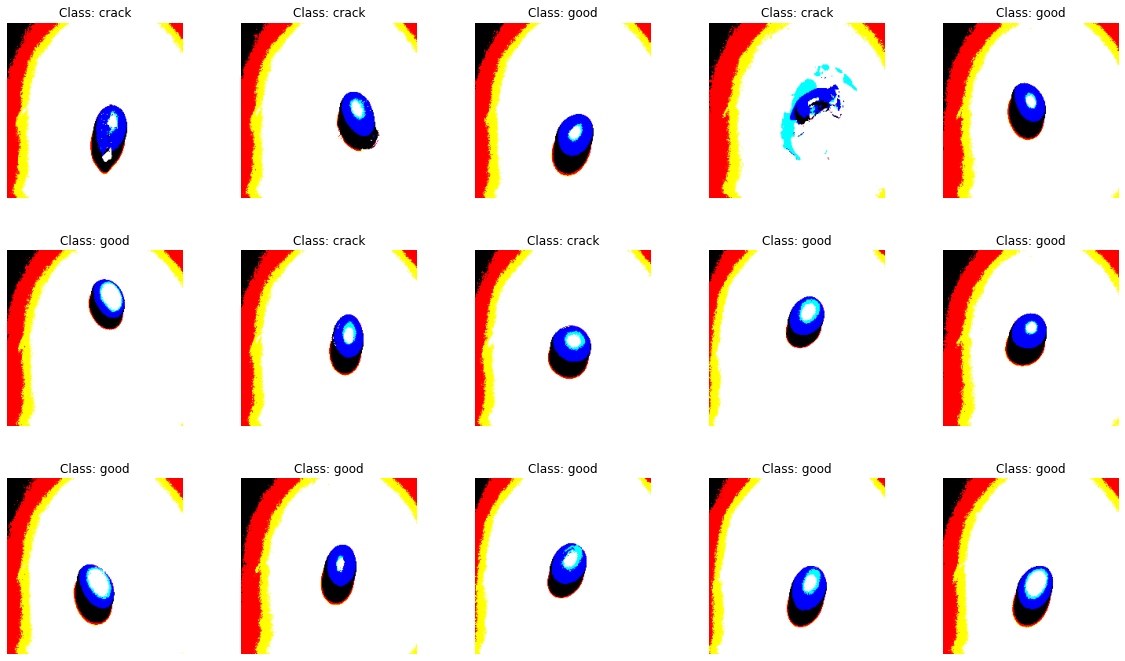

In [22]:
#data visualizing in the rgb format for easy classification

labels = [k for k in train_image.class_indices]
sample_generate = train_image.__next__()

images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In [25]:
#putting up the agument layers for VGG19

augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [27]:
#applying the model VGG19

pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape = (224, 224, 3), 
    include_top = False, 
    weights = 'imagenet', 
    pooling = 'max'
 )
pretrained_model.trainable = False

In [38]:
#declaring the checkpoint path

checkpoint_path = 'broken_egg_classification_checkpoint'

In [62]:
#creating checkpoint_callback layer

checkpoint_callback = ModelCheckpoint(checkpoint_path, 
                                  save_wiights_only = True, 
                                  monitor = 'val_accuracy', 
                                  save_best_only = True)
#creating the early stopping layer
early_stopping = EarlyStopping(monitor = 'val_loss', 
                               patience = 5, 
                               restore_best_weights = True)
#creating the reduce LROn plateau layer
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.2, 
                              patience = 3, 
                              min_lr = 0.0001)

In [63]:
#inputs for applying model

inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation = 'relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

In [64]:
#output for applying model

outputs = Dense(2, activation = 'softmax')(x)

In [65]:
#creating the model

model = Model(inputs = inputs, outputs = outputs)

In [66]:
#compiling the model

model.compile(optimizer = Adam(0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [67]:
#creating the tensorboard_callback

from tensorflow.keras.callbacks import TensorBoard
import datetime

def create_tensorboard_callback(log_dir, experiment_name):
    log_dir = log_dir + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


In [68]:
#appling the model

history = model.fit(train_image, 
                    steps_per_epoch = len(train_image),
                    validation_data = validation_image, 
                    validation_steps = len(validation_image), 
                    epochs = 100, 
                    callbacks = [early_stopping,
                                 create_tensorboard_callback("training_logs","eggs_classification"),
                                 checkpoint_callback,
                                 reduce_lr])


Saving TensorBoard log files to: training_logs/eggs_classification/20230506-104120
Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.7453 - accuracy: 0.6702 

INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


9/9 [==============================] - 345s 38s/step - loss: 0.7453 - accuracy: 0.6702 - val_loss: 1.6508 - val_accuracy: 0.5429 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 313s 36s/step - loss: 0.2751 - accuracy: 0.8830 - val_loss: 2.8147 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 279s 32s/step - loss: 0.2668 - accuracy: 0.9078 - val_loss: 2.5811 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 270s 31s/step - loss: 0.1820 - accuracy: 0.9184 - val_loss: 2.1390 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 272s 32s/step - loss: 0.1338 - accuracy: 0.9468 - val_loss: 1.5546 - val_accuracy: 0.5143 - lr: 2.0000e-04
Epoch 6/100
9/9 [==============================] - 269s 30s/step - loss: 0.1171 - accuracy: 0.9610 - val_loss: 1.1028 - val_accuracy: 0.5000 - lr: 2.0000e-04
Epoch 7/100
9/9 [==============================] - 321s 37s/step - loss: 0.1270 

INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


9/9 [==============================] - 407s 47s/step - loss: 0.1156 - accuracy: 0.9574 - val_loss: 0.7147 - val_accuracy: 0.5714 - lr: 2.0000e-04
Epoch 9/100
9/9 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9752 

INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


9/9 [==============================] - 387s 44s/step - loss: 0.0722 - accuracy: 0.9752 - val_loss: 0.6387 - val_accuracy: 0.6429 - lr: 2.0000e-04
Epoch 10/100
9/9 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9504 

INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


9/9 [==============================] - 335s 37s/step - loss: 0.1115 - accuracy: 0.9504 - val_loss: 0.5912 - val_accuracy: 0.6714 - lr: 2.0000e-04
Epoch 11/100
9/9 [==============================] - ETA: 0s - loss: 0.1014 - accuracy: 0.9716 

INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


9/9 [==============================] - 362s 41s/step - loss: 0.1014 - accuracy: 0.9716 - val_loss: 0.5488 - val_accuracy: 0.7714 - lr: 2.0000e-04
Epoch 12/100
9/9 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9716 

INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


9/9 [==============================] - 359s 42s/step - loss: 0.0882 - accuracy: 0.9716 - val_loss: 0.5687 - val_accuracy: 0.8143 - lr: 2.0000e-04
Epoch 13/100
9/9 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.9716 

INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


INFO:tensorflow:Assets written to: broken_egg_classification_checkpoint\assets


9/9 [==============================] - 364s 42s/step - loss: 0.0867 - accuracy: 0.9716 - val_loss: 0.5860 - val_accuracy: 0.8286 - lr: 2.0000e-04
Epoch 14/100
9/9 [==============================] - 336s 38s/step - loss: 0.1275 - accuracy: 0.9539 - val_loss: 0.6047 - val_accuracy: 0.8286 - lr: 2.0000e-04
Epoch 15/100
9/9 [==============================] - 292s 33s/step - loss: 0.0934 - accuracy: 0.9681 - val_loss: 0.6139 - val_accuracy: 0.8286 - lr: 1.0000e-04
Epoch 16/100
9/9 [==============================] - 300s 35s/step - loss: 0.1143 - accuracy: 0.9539 - val_loss: 0.6292 - val_accuracy: 0.8286 - lr: 1.0000e-04


In [71]:
results = model.evaluate(test_image, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.27717
Test Accuracy: 88.24%


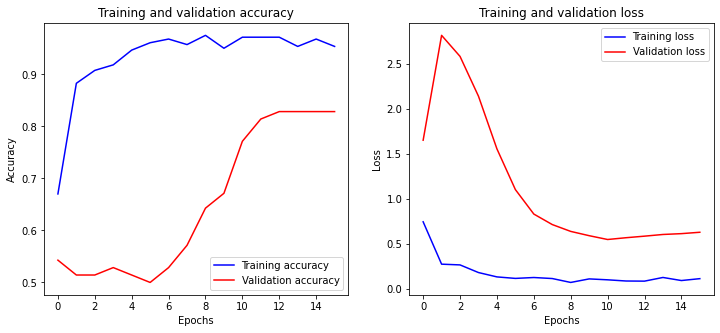

In [84]:
#plotting the chart for validation loss and validation accuracy against the epochs 

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()


In [86]:
#saving the model

model.save('model_VGG19.h5')

In [88]:
#predicting the model on the images

pred = model.predict(test_image)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_image.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

1/1 [==============================] - 21s 21s/step
The first 5 predictions: ['crack', 'crack', 'crack', 'good', 'good']
